# Projekt Airbnb Praha

In [140]:
#Importy
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import shap


np.random.seed(123)
plt.rc('figure', figsize=(16, 8))
PREVIOUS_MAX_ROWS = pd.options.display.max_rows
pd.options.display.max_rows = 20
np.set_printoptions(precision=4,suppress=True)

## Popis datasetu

Vybraný dataset vznikl v rámci projektu "Inside Airbnb", který shromažďuje data týkající se nabídek Airbnb ubytování v různých městech po celém světě. V případě zvoleného datasetu se jedná konkrétně o Prahu a její okolí. Dataset obsahuje celkem 8427 záznamů shromážděných za poslednách 12 měsíců k 18. řijínu 2023. Každý ze záznamů přitom disponuje následujícími charakteristikami (atributy):  

"id": ID nabídky (ubytování).
"name": Název ubytování a jeho průměrné hodnocení. 
"host_id": ID hosta.
"host_name": Jméno hosta.
"neighbourhood_group": Čtvrť města (v ČR neklasifikováno).
"neighbourhood": Část města (Prahy).
"latitude": Souřadnice zeměpisné šířky ubytování. 
"longitude": Souřadnice zeměpisné délky ubytování.
"room_type": Typ hostem využitého ubytování (soukromý pokoj, sdílený pokoj, hotelový pokoj, celý dům/apartmán).
"price": Cena daného ubytování na 1 noc.
"minimum_nights": Minimální počet nocí, na které si host může dané ubytování zarezervovat.
"number_of_reviews": Počet recenzí, které dané ubytování za celou dobu své působnosti na platformě Airbnb. 
"last_review": Datum posledního hodnocení daného ubytování. 
"reviews_per_month": Průměrný počet hodnocení, které dané ubytování obdrží za 1 měsíc. 
"calculated_host_listings_count": Celkový počet ubytování, které hostitel nabízí.
"availability_365": Počet dní v roce, kdy je ubytování dostupné pro rezervaci. 
"number_of_reviews_ltm": Počet hodnocení daného ubytování za poslední měsíc.
"license": Počet licencí daného ubytování. 

Lze nahlédnout, že atribut "name" pod sebou skrývá dvě informace - název ubytování a jeho průměrné hodnocení. Ještě před začátkem jakékoliv další práce s daty proto bylo z atributu "name" průměrné hodnocení daného ubytování extrahováno a následně přidáno jakožto nový atribut s názvem "star_rating". 

In [115]:
# Načtení dat
df = pd.read_csv(r'C:\Users\neumannv\Desktop\škola\DataX\Airbnb_data_analysis\data\raw\Praha_listings.csv')

# Extrakce číselného hodnoceni z proměnné (textového pole) name (název hotelu)
df['star_rating'] = df['name'].str.extract(r'★([\d.]+)').astype(float)
df = df.drop('name', axis=1)
print(df['star_rating'])

0        NaN
1       4.92
2       4.71
3       4.94
4       4.71
        ... 
8422     NaN
8423     NaN
8424     NaN
8425     NaN
8426     NaN
Name: star_rating, Length: 8427, dtype: float64


Detailní pohled na hodnoty atributů (s přidáním atributu "star_rating") pak poskytuje znázornění celého datasetu níže. 

In [116]:
# Zobrazení datasetu 
print(df)
print("Rows     : ", df.shape[0])
print("Columns  : ", df.shape[1])
print("\nFeatures : ", df.columns.tolist())

                      id    host_id         host_name  neighbourhood_group  \
0                   3884       3128            Regina                  NaN   
1                  23163       5282             Klara                  NaN   
2                  23169       5282             Klara                  NaN   
3                  26755     113902        Daniel+Bea                  NaN   
4                  30762       5282             Klara                  NaN   
...                  ...        ...               ...                  ...   
8422  919539998946285600  507431786  Wonderful Prague                  NaN   
8423  919543826231775270  507431786  Wonderful Prague                  NaN   
8424  919551433982381664  507431786  Wonderful Prague                  NaN   
8425  919554095695693837  507431786  Wonderful Prague                  NaN   
8426  919665154913777534  419022428              Ulvi                  NaN   

     neighbourhood   latitude  longitude        room_type  pric

Tento dataset byl využit pro úlohu predikce lokace ubytování hosta vzhledem k hodnotám zbylých atributů. V kontextu konkrétního datasetu je tedy cílovým atributem atribut "neighbourhood". Ostatní atributy jsou pak atributami tzv. vstupními.


## Průzkumová analýza dat 

V rámci průzkumové analýzy dat byl nejprve zjištěn počet nenulových, chybějících a unikátních hodnot v rámci jednotlivých atributů společně s datovým typem atributů a početem záznamů pro každou kategorii cílového atributu. Počet záznamů pro každou kategorii cílového atributu byl ještě seřazen dle velikosti - od největšího počtu po nejmenší. 

In [117]:
# Vypsání počtu nenulových hodnot pro každý atribut
print(df.info()) 
print("Rows     : ", df.shape[0])
print("Columns  : ", df.shape[1])
# vypsání počtu chybějících hodnot pro každý atribut
print("\nNumber of missing values in each column : \n", df.isna().sum()) 
# vypsání počtu unikátnch hodnot pro každý atribut
print("\nNumber of unique values in each column : \n", df.nunique()) 
# vypsání počtu záznamů pro každou třídu cílového atributu
neighbourhood_counts = df['neighbourhood'].value_counts().reset_index()
neighbourhood_counts.columns = ['neighbourhood', 'count']  # přejmenování sloupců
neighbourhood_counts = neighbourhood_counts.sort_values(by='count', ascending=False) # seřazení kategorií sestupně dle počtu záznamů-řádků
print("\nNumber of raws for each target value : \n", neighbourhood_counts)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8427 entries, 0 to 8426
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              8427 non-null   int64  
 1   host_id                         8427 non-null   int64  
 2   host_name                       8427 non-null   object 
 3   neighbourhood_group             0 non-null      float64
 4   neighbourhood                   8427 non-null   object 
 5   latitude                        8427 non-null   float64
 6   longitude                       8427 non-null   float64
 7   room_type                       8427 non-null   object 
 8   price                           8427 non-null   int64  
 9   minimum_nights                  8427 non-null   int64  
 10  number_of_reviews               8427 non-null   int64  
 11  last_review                     7470 non-null   object 
 12  reviews_per_month               74

Z výpisu je zřejmé, že atributy "neighbourhood_group" a "license" Airbnb v Praze nepoužívá, nebo-li celkový počet chybějících hodnot je roven celkovému počtu záznamů. Chybějíci hodnoty vykazují dále také atributy "last_review", "reviews_per_month" a "star_rating". V rámci fáze předzpracování tak bude u všech výše zmíněných atributů provedeno oštěření chybějícíh hodnot. 
Z výpisu lze dále nahlédnout, že se v datasetu nachází obrovské množství kategorií cílového atributu "neighbourhood", které mají velmi malé zastoupení (v jednotkách do desítek záznamů). Konkrétně se jedná o kategorie s indexem větším než 9. Vzhledem k opravdu nízkému počtu záznamů by zmíněné kategorie nehrály ve výsledné předpovědi téměř žádný vliv. Naopak by mohly způsobit komplikace, proto jsme se rozhodli je odebrat. 

In [118]:
# Vyfiltrování 10 lokalit (instancí proměnné neighbourhood) s největším počtem záznamů (ostatní kategorie lze odstranit, neboť obsahují příliš málo záznamů - řádků)
top_10_neighbourhoods = neighbourhood_counts.head(10) 
print(top_10_neighbourhoods)

# odebrání řádků náležících instancím, které nepatří do TOP 10 instancí
filtered_df = df[df['neighbourhood'].isin(top_10_neighbourhoods['neighbourhood'])]

# aktualizace stávajícího datasetu 
df=filtered_df

  neighbourhood  count
0       Praha 1   3120
1       Praha 2   1638
2       Praha 3    876
3       Praha 5    657
4       Praha 8    418
5       Praha 7    362
6      Praha 10    298
7       Praha 4    284
8       Praha 6    271
9       Praha 9     99


Pro úplnost popisu upraveného datového souboru byl ještě vypsán celkový počet záznamů po redukci a počet nenulových, chybějících a unikátních hodnot v rámci jednotlivých atributů.

In [119]:
# Vypsání počtu nenulových hodnot pro každý atribut
print(df.info()) 
print("Rows     : ", df.shape[0])
print("Columns  : ", df.shape[1])
# vypsání počtu chybějících hodnot pro každý atribut
print("\nNumber of missing values in each column : \n", df.isna().sum()) 
# vypsání počtu unikátnch hodnot pro každý atribut
print("\nNumber of unique values in each column : \n", df.nunique()) 

<class 'pandas.core.frame.DataFrame'>
Index: 8023 entries, 0 to 8426
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              8023 non-null   int64  
 1   host_id                         8023 non-null   int64  
 2   host_name                       8023 non-null   object 
 3   neighbourhood_group             0 non-null      float64
 4   neighbourhood                   8023 non-null   object 
 5   latitude                        8023 non-null   float64
 6   longitude                       8023 non-null   float64
 7   room_type                       8023 non-null   object 
 8   price                           8023 non-null   int64  
 9   minimum_nights                  8023 non-null   int64  
 10  number_of_reviews               8023 non-null   int64  
 11  last_review                     7146 non-null   object 
 12  reviews_per_month               7146 no

Lze nahlédnout, že tímto krokem došlo k redukci dat z původních 8427 na 8023 záznamů (tj. o necelých 5 %) a ruku v ruce s tím došlo k poklesu počtu chybějících hodnot u atributů "neighbourhood_group", "last_review", "reviews_per_month", "license" a "star_rating". Odstranění těchto kategorií vedlo k výraznému zpřehlednění a zkonkrétnění definované úlohy. Již po průzkumové analýze takto upraveného datového souboru však bylo zřejmé, že dataset je značně nevyvážený (tj. Praha 1 ve všech ohledech oproti zbylým kategoriím dominovala) a tedy přesnost předpovědí, resp. úspěšnost modelů, bude pravděpodobně velmi nízká. Tato hypotéza se následně potvrdila. Za účelem vybalancování dat při zachování smysluplnosti definované úlohy, proto došlo ještě ke sloučení dílčích částí Prahy dle geografického rozložení do 4 celků, konkrétně: 
* 1. kategorie (Staré město): Praha 1
* 2. kategorie (Nové město): Praha 2 + Praha 3 
* 3. kategorie (Jiho-východní část Prahy): Praha 4 + Praha 5 + Praha 9 + Praha 10
* 4. kategorie (Severo-západní část Prahy): Praha 6 + Praha 7 + Praha 8 

In [120]:
# Určení kategorií podle zadání
def assign_category(neighbourhood):
    if neighbourhood == 'Praha 1':
        return "Old_Town"
    elif neighbourhood in ['Praha 2', 'Praha 3']:
        return "New_Town"
    elif neighbourhood in ['Praha 4', 'Praha 5', 'Praha 9', 'Praha 10']:
        return "South_East"
    elif neighbourhood in ['Praha 7', 'Praha 8', 'Praha 6']:
        return "North_West"
    else:
        return None

# aplikace funkce na sloupec 'neighbourhood' a přepsání hodnot
df['neighbourhood'] = df['neighbourhood'].map(assign_category)
neighbourhood_counts = df['neighbourhood'].value_counts().reset_index()
print(neighbourhood_counts)


  neighbourhood  count
0      Old_Town   3120
1      New_Town   2514
2    South_East   1338
3    North_West   1051


In [121]:
neighbourhood_counts = df['neighbourhood'].value_counts().reset_index()
print(neighbourhood_counts)

  neighbourhood  count
0      Old_Town   3120
1      New_Town   2514
2    South_East   1338
3    North_West   1051


Následující čast sekce tak představuje průzkumovou analýzu dat po redukci a následném sloučení kategorií cílového atributu. 

V rámci průzkumové analýzy nejprve zjišťujeme rozložení jednotlivých typů hostem využitých ubytování pro každý z výše definovaných pražských celků.  

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='neighbourhood', ylabel='count'>

Text(0.5, 1.0, 'Count of room types by location')

Text(0.5, 0, 'Location')

Text(0, 0.5, 'Count')

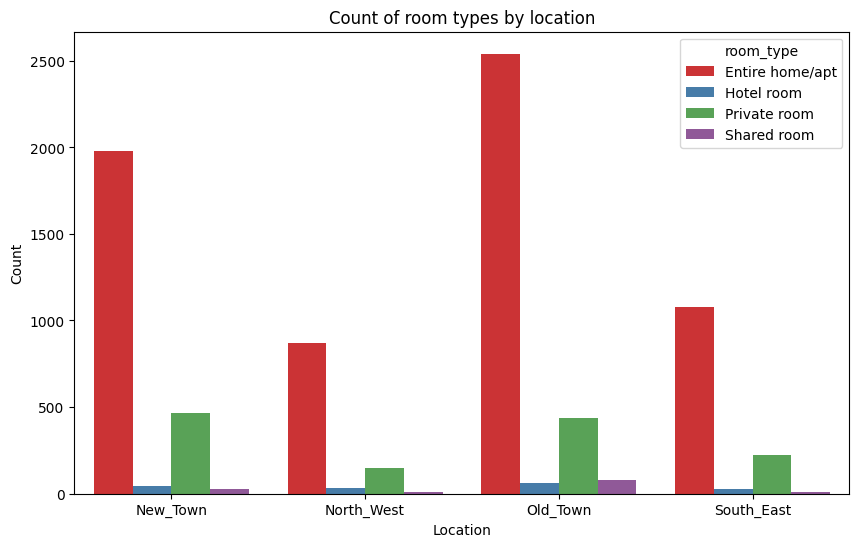

In [122]:
# Rozložení typů hostem využitého ubytování ve 4 pražských celcích
count_data = df.groupby(['neighbourhood', 'room_type']).size().reset_index(name='count')

# znázornění
plt.figure(figsize=(10, 6))
sns.barplot(x='neighbourhood', y='count', hue='room_type', data=count_data, palette='Set1')
plt.title('Count of room types by location')
plt.xlabel('Location')
plt.ylabel('Count')
plt.show()

Z výstupu je zřejmé, že ve všech lokalitách je v nepřiměřeně přesahujícím poměru zastoupena hodnota "Entire home/apt".

Pro jednotlivé pražské celky byla následně vypočtena a znázorněna cena ubytování za jednu noc. 

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='neighbourhood'>

Text(0.5, 0, 'Location')

Text(0, 0.5, 'Average price')

Text(0.5, 1.0, 'Average price of accommodation in each location')

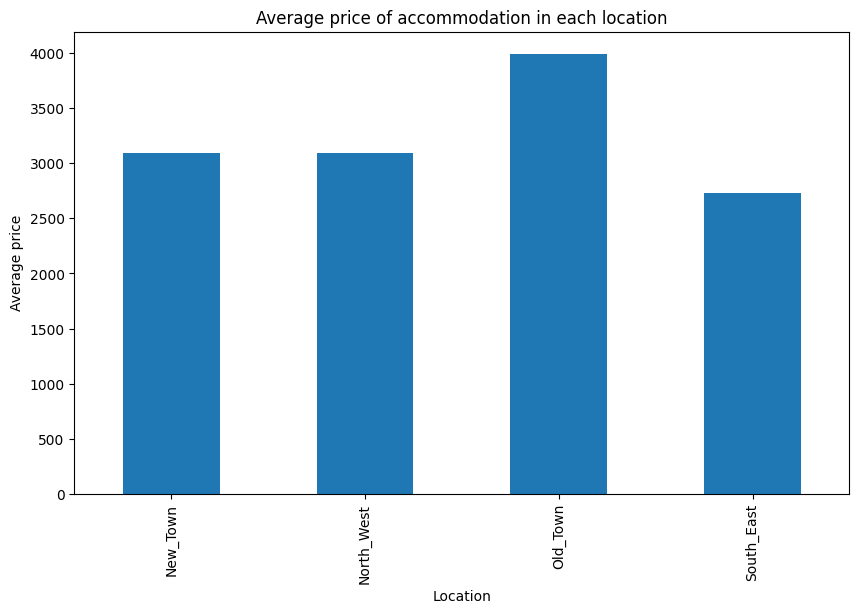

In [123]:
# Průměrná cena ubytování ve 4 pražských celcích
mean_price = df.groupby('neighbourhood')['price'].mean()

# znázornění
plt.figure(figsize=(10, 6))
mean_price.plot(kind='bar')
plt.xlabel('Location')
plt.ylabel('Average price')
plt.title('Average price of accommodation in each location')
plt.show()

Z výsledku je zřejmé, že průměrné ceny ubytování za jednu noc se pohybují v rozmezí od cca 2 500 Kč, až do cca 4 000 Kč. Nejnižší průměrné ceny ubytování za jednu noc vykazují ubytování v celku jiho-východ, zatímco nejvyyší ceny, pochopitelně, ubytování na Starém městě.

Dále byl zjištěn a znázornněn počet hostem poskytnutých hodnocení jednotlivých ubytování nacházejících se ve jednotlivých pražských celcích. 

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='neighbourhood', ylabel='number_of_reviews'>

Text(0.5, 1.0, 'Sum of number of reviews by location')

Text(0.5, 0, 'Location')

Text(0, 0.5, 'Sum of number of reviews')

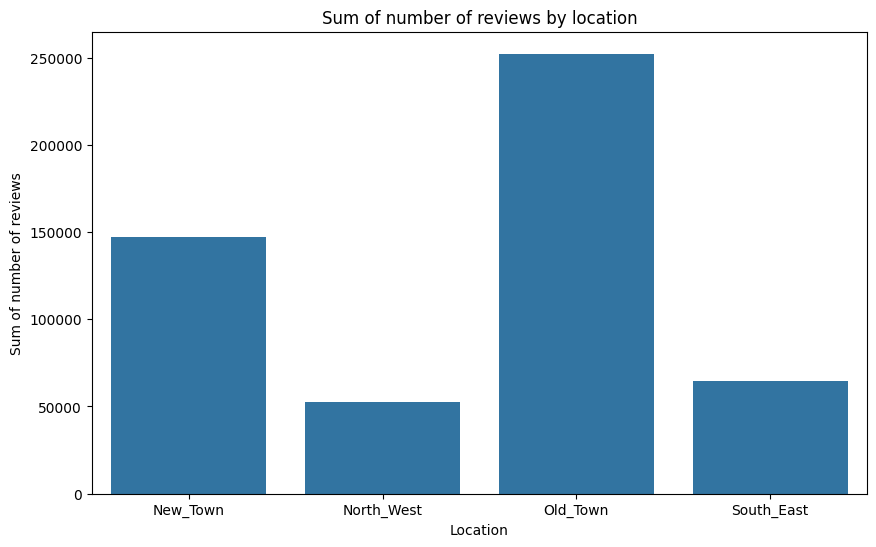

In [124]:
# Počty poskytnutých hodnocení jednotlivých ubytování nacházejících se ve 4 pražských celcích
sum_reviews_by_neighbourhood = df.groupby('neighbourhood')['number_of_reviews'].sum().reset_index()

# znázornění
plt.figure(figsize=(10, 6))
sns.barplot(x='neighbourhood', y='number_of_reviews', data=sum_reviews_by_neighbourhood)
plt.title('Sum of number of reviews by location')
plt.xlabel('Location')
plt.ylabel('Sum of number of reviews')
plt.show()

Lze nahlédnout, že počty hodnocení jednotlivých ubytování jsou opět značně nevyvážené. Staré město (Praha 1) stále disponuje oproti zbylým pražským celkům téměř 2x více hodnoceními. I tento výstup je však smysluplný, neboť se dá předpokládat, že nejvyšší poptávka po ubytování a tedy i nejvýšší počet na Airbnb dostupných ubytování bude v centru. S počtem na Airbnb dostupných ubytování je pak úzce spjata také hodnota celkového počtu hodnocení.

Dále bylo také zanalyzováno také průměrné hodnocení ubytování v jednotlivých pražských celcích. 

<Axes: xlabel='neighbourhood'>

Text(0.5, 0, 'Location')

Text(0, 0.5, 'Average star rating')

Text(0.5, 1.0, 'Average star rating of accommodation in each location')

(4.0, 5.0)

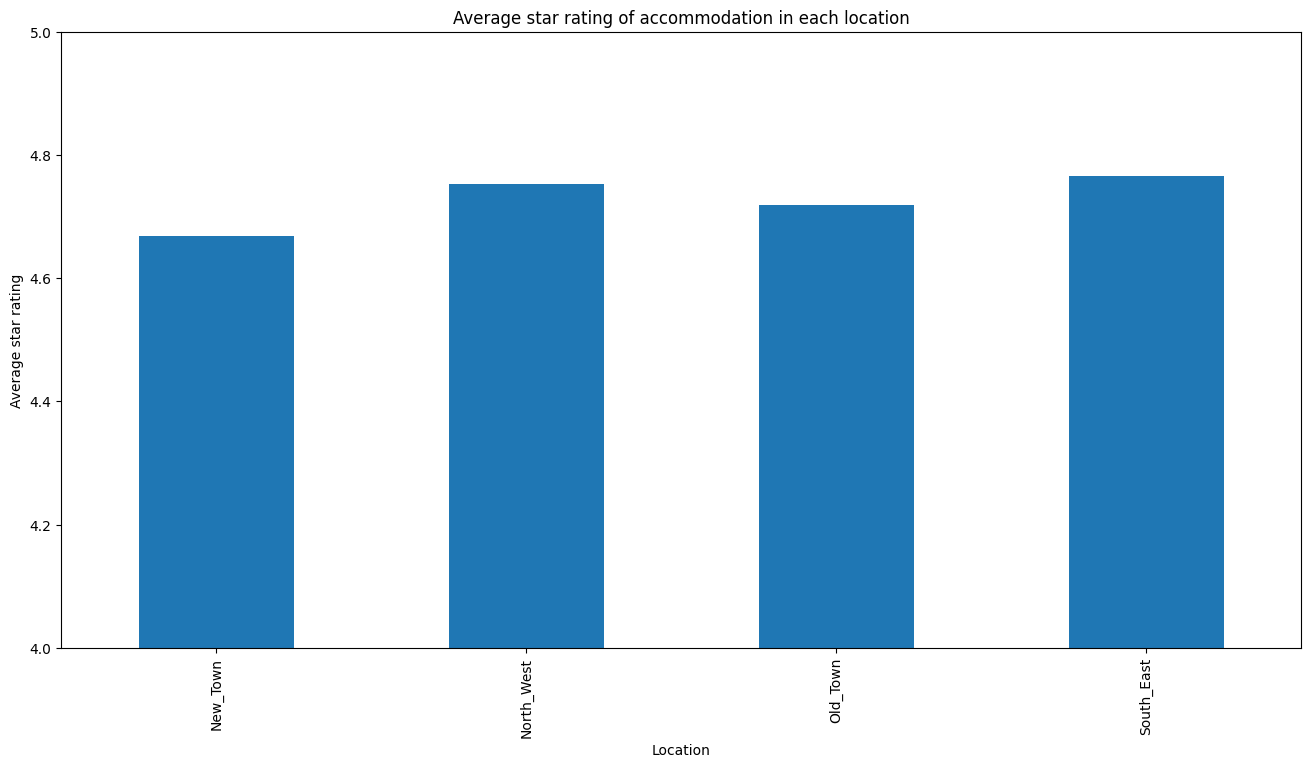

In [125]:
# Průměrné hodnocení ubytování ve 4 pražských celcích
mean_star_rating = df.groupby('neighbourhood')['star_rating'].mean()
mean_star_rating.plot(kind='bar')

# znázornění
plt.xlabel('Location')
plt.ylabel('Average star rating')
plt.title('Average star rating of accommodation in each location')
plt.ylim(4,5)
plt.show()

Z výsledků je zřejmé, že průměrné hodnocení ubytování dosahuje velmi vysokých a navzájem podobných hodnot. Tento výsledek však není vzhledem ke společným charakteristikám vybraného vzorku lokalit (centrum města, lukrativní městské části) ničím překvapivým. 

Běžným krokem v rámci průzkumové analýzy dat je dále analýza korelační matice, která pomáhá identifikovat lineární vztahy a závislosti mezi jednotlivými dvojicemi atributů, hlavně pak atributů vstupních a atributu cílového. Pro klasifikační úlohu s vícekategoriálním cílovým atributem však tato analýza není nejvhodnější metodou, neboť jsou tradiční korelační koeficienty, jako je Pearsonova korelace, určeny pro spojité atributy (za které lze považovat i binární cílové atributy) a nemusí tak správně zachytit příslušné vztahy.
Na základě těchto úvah byl tedy pomocí korelační matice analyzován pouze vztah mezi vstupními atributy. 

<Figure size 1200x800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation matrix')

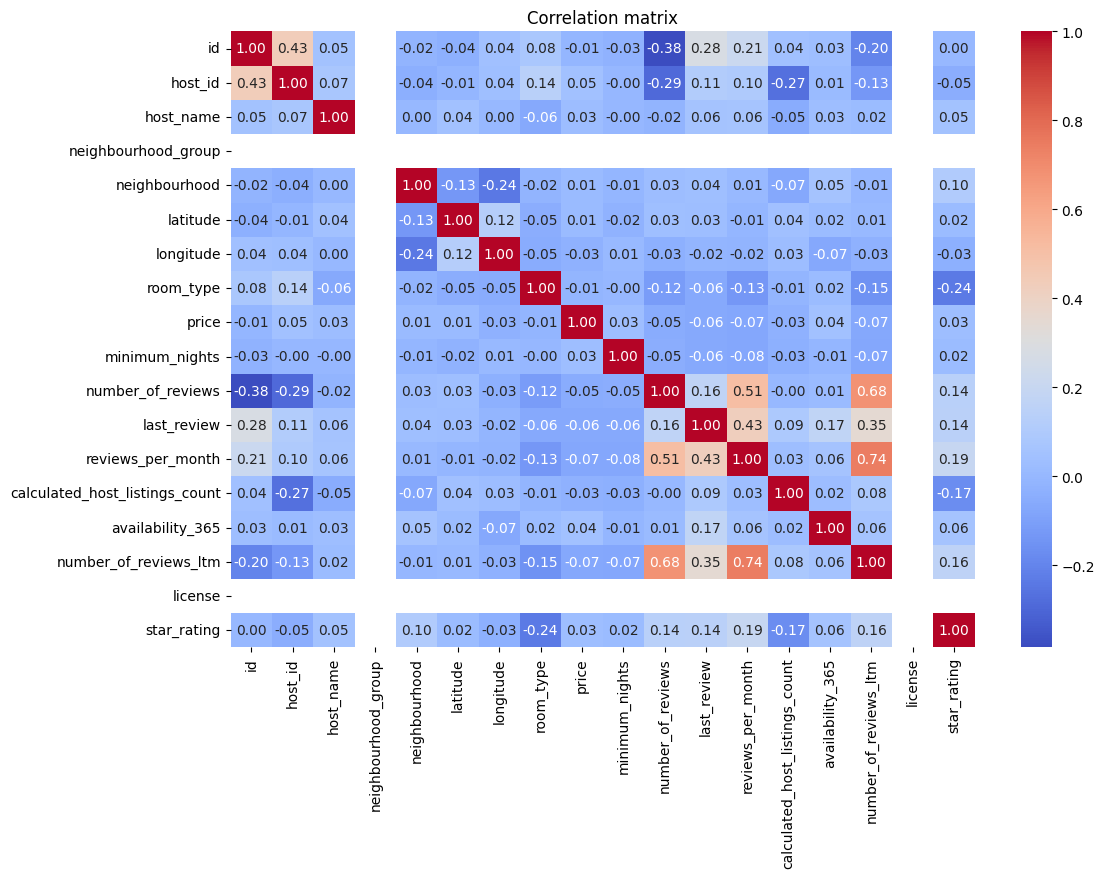

In [126]:
#transformace kategoriálních (textových nebo řetězcových) hodnot na číselné.
label_encoder = LabelEncoder()
corr_data = df.copy()
corr_data['room_type'] = label_encoder.fit_transform(corr_data['room_type'])
corr_data['host_name'] = label_encoder.fit_transform(corr_data['host_name'])
corr_data['last_review'] = label_encoder.fit_transform(corr_data['last_review'])
corr_data['neighbourhood'] = label_encoder.fit_transform(corr_data['neighbourhood'])

# Vztah mezi jednotlivými atributy pomocí korelační matice
correlation_matrix = corr_data.corr()

# vytvoření heatmap pomocí seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation matrix')
plt.show()

#Odstranění DataFramu corr_data
corr_data = corr_data.iloc[0:0]

Z výstupu je zřejmé, že většina atributů není korelována. Přímou závislosti lze pozorovat mezi atributy "review_per_month", tj. počtem hodnocení za poslední měsíc a "number_of_reviews_ltm", tj. průměrným počtem hodnocení za měsíc, a dále pak mezi atributy "number_of_reviews",tj. celkovým počtem hodnocení, a  "number_of_reviews_ltm", tj. průměrným počtem hodnocení za měsíc. Tyto závislosti vychází z podstaty atributů a jsou tak v obou případech logická - vyšší celkový počet hodnocení za poslední měsíc povede i k vyššímu průměrnému počtu hodnocení za jeden měsíc, stejně jako vyšší celkový počet hodnocení souvisí s vyšším průměrným hodnocení za měsíc.

Zajímavé pozorování je nepřímé závislosti mezi atributy "id" a "number_of_reviews", tj. počtem hodnocení. Za předpokladu, že databáze Airbnb si generuje id číselnou sekvencí, mohlo by toto znamenat, že starší ubytování má menší id a s ohledem na počet hodnocení mají starší ubytování méně hodnocení. Již nedostupné (zrušené) ubytování nemohou sbírat nová hodnocení. Za stejného předpokladu bychom mohli uvažovat stejně o atributech "host_id" a "number_of_reviews".

V rámci průzkumové analýzy byl na zavěr ještě znázorněno rozložení hodnot význačných numerických atributů, konkrétně atributů "price", tj. výše cen ubytování,  "number_of_reviews", počtu poskytnutých hodnocení  a "star_rating", výše hodnocení.

<Figure size 1800x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Price distibution')

Text(0.5, 0, 'Price')

Text(0, 0.5, 'Number of records')

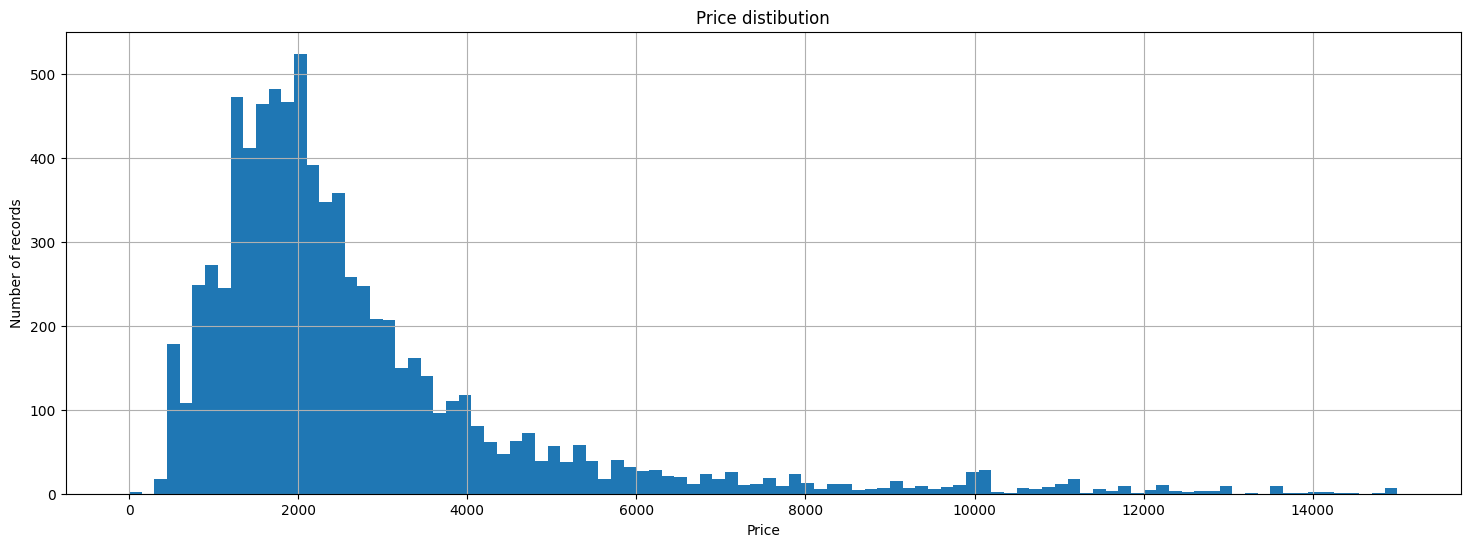

In [127]:
# Rozložení výše cen ubytování
plt.figure(figsize=(18, 6))
df['price'].hist(bins=100, range=(0, 15000))
plt.title('Price distibution')
plt.xlabel('Price')
plt.ylabel('Number of records')
plt.show()

<Figure size 1800x600 with 0 Axes>

([<matplotlib.axis.XTick at 0x2d7cd2ea910>,
 [Text(0.0, 0, '0.0'),
  Text(0.4203847028988705, 0, '1.0'),
  Text(0.840769405797741, 0, '1.0'),
  Text(1.2611541086966114, 0, '3.0'),
  Text(1.681538811595482, 0, '4.0'),
  Text(2.101923514494352, 0, '7.0'),
  Text(2.5223082173932228, 0, '11.0'),
  Text(2.9426929202920933, 0, '18.0'),
  Text(3.363077623190964, 0, '28.0'),
  Text(3.7834623260898343, 0, '43.0'),
  Text(4.203847028988704, 0, '66.0'),
  Text(4.624231731887575, 0, '101.0'),
  Text(5.0446164347864455, 0, '154.0'),
  Text(5.4650011376853165, 0, '235.0'),
  Text(5.885385840584187, 0, '359.0'),
  Text(6.3057705434830575, 0, '547.0'),
  Text(6.726155246381928, 0, '833.0'),
  Text(7.146539949280798, 0, '1269.0'),
  Text(7.566924652179669, 0, '1932.0'),
  Text(7.987309355078539, 0, '2942.0'),
  Text(8.407694057977409, 0, '4480.0'),
  Text(8.82807876087628, 0, '6822.0'),
  Text(9.24846346377515, 0, '10388.0'),
  Text(9.668848166674021, 0, '15816.0'),
  Text(10.089232869572891, 0, '24081

Text(0.5, 0, 'Price')

Text(0, 0.5, 'Frekvency')

Text(0.5, 1.0, 'Logaritmic transformed prices distribution')

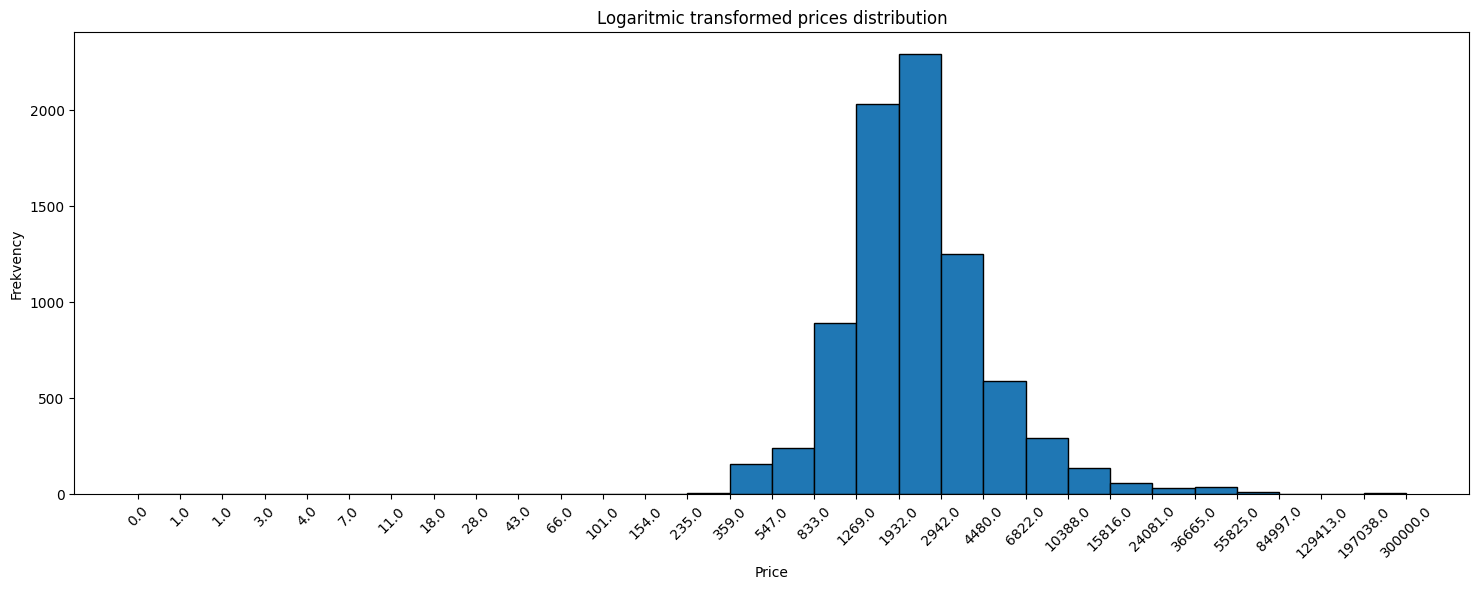

In [128]:
# Rozložení výše cen v logaritmickém měřítku - mají těžký chvost
plt.figure(figsize=(18, 6))

# logaritmická transformace dat o cenách
transformed_price = np.log1p(df['price'])
n, bins, patches = plt.hist(transformed_price, bins=30, edgecolor='black')

# převod hodnot na ose x z logaritmického měřítka zpět na původní měřítko pro popisky
bin_labels = np.expm1(bins)

# nastavení hodnot na ose x pro zobrazení původních cen
plt.xticks(bins, labels=np.round(bin_labels, 0), rotation=45)
plt.xlabel('Price')
plt.ylabel('Frekvency')
plt.title('Logaritmic transformed prices distribution')

# zobrazení histogramu
plt.show()

Rozložení počtu hodnocení:

<Figure size 1800x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Number of reviews distribution')

Text(0.5, 0, 'Number of reviews')

Text(0, 0.5, 'Number of records')

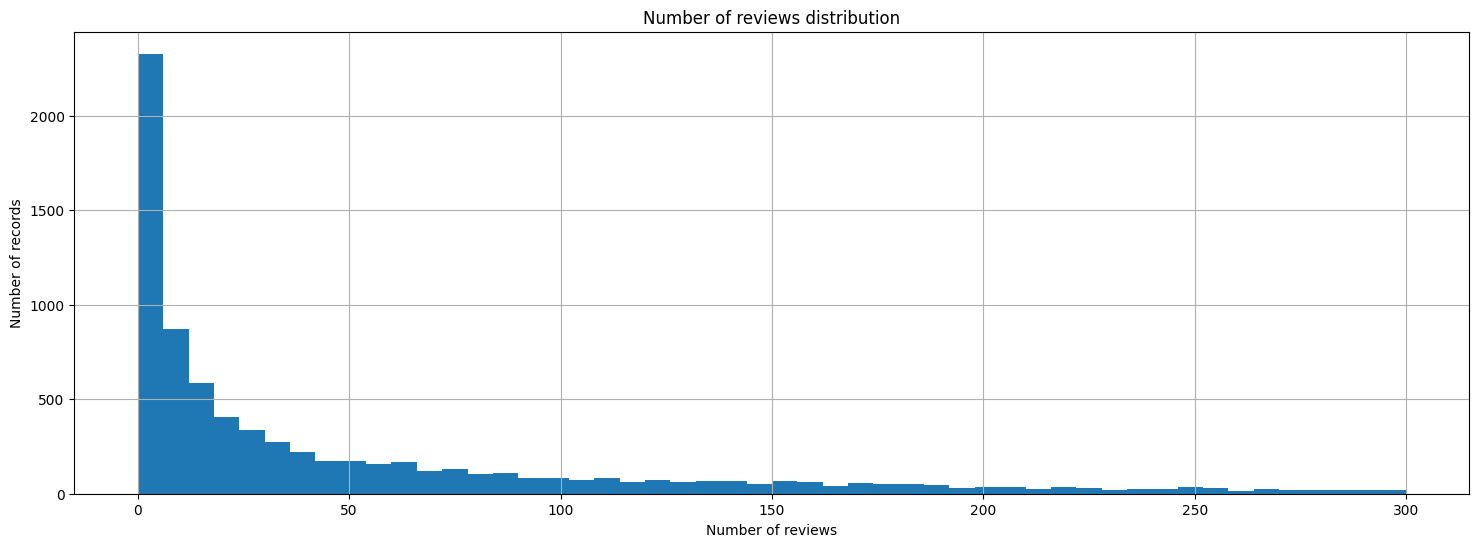

1660

In [129]:
# Rozložení počtu hodnocení
plt.figure(figsize=(18, 6))
df['number_of_reviews'].hist(bins=50 , range=(0, 300))
plt.title('Number of reviews distribution')
plt.xlabel('Number of reviews')
plt.ylabel('Number of records')
plt.show()
max(df['number_of_reviews'])


Graf potvrzuje to, co bylo nastíněno již výše - u velkého množství záznamů je počet hodnocení roven 0 (nebo zcela chybí). Navíc lze usoudit, že nejvýraznější část záznamů disponuje nejvýše 50 hodnoceními.

<Figure size 2000x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Star rating distribution')

Text(0.5, 0, 'Star rating')

Text(0, 0.5, 'Number of records')

([<matplotlib.axis.XTick at 0x2d7ca8fd990>,
 [Text(3.0, 0, '3.0'),
  Text(3.1, 0, '3.1'),
  Text(3.2, 0, '3.2'),
  Text(3.3000000000000003, 0, '3.3'),
  Text(3.4000000000000004, 0, '3.4'),
  Text(3.5000000000000004, 0, '3.5'),
  Text(3.6000000000000005, 0, '3.6'),
  Text(3.7000000000000006, 0, '3.7'),
  Text(3.8000000000000007, 0, '3.8'),
  Text(3.900000000000001, 0, '3.9'),
  Text(4.000000000000001, 0, '4.0'),
  Text(4.100000000000001, 0, '4.1'),
  Text(4.200000000000001, 0, '4.2'),
  Text(4.300000000000001, 0, '4.3'),
  Text(4.400000000000001, 0, '4.4'),
  Text(4.500000000000002, 0, '4.5'),
  Text(4.600000000000001, 0, '4.6'),
  Text(4.700000000000001, 0, '4.7'),
  Text(4.800000000000002, 0, '4.8'),
  Text(4.900000000000002, 0, '4.9'),
  Text(5.000000000000002, 0, '5.0')])

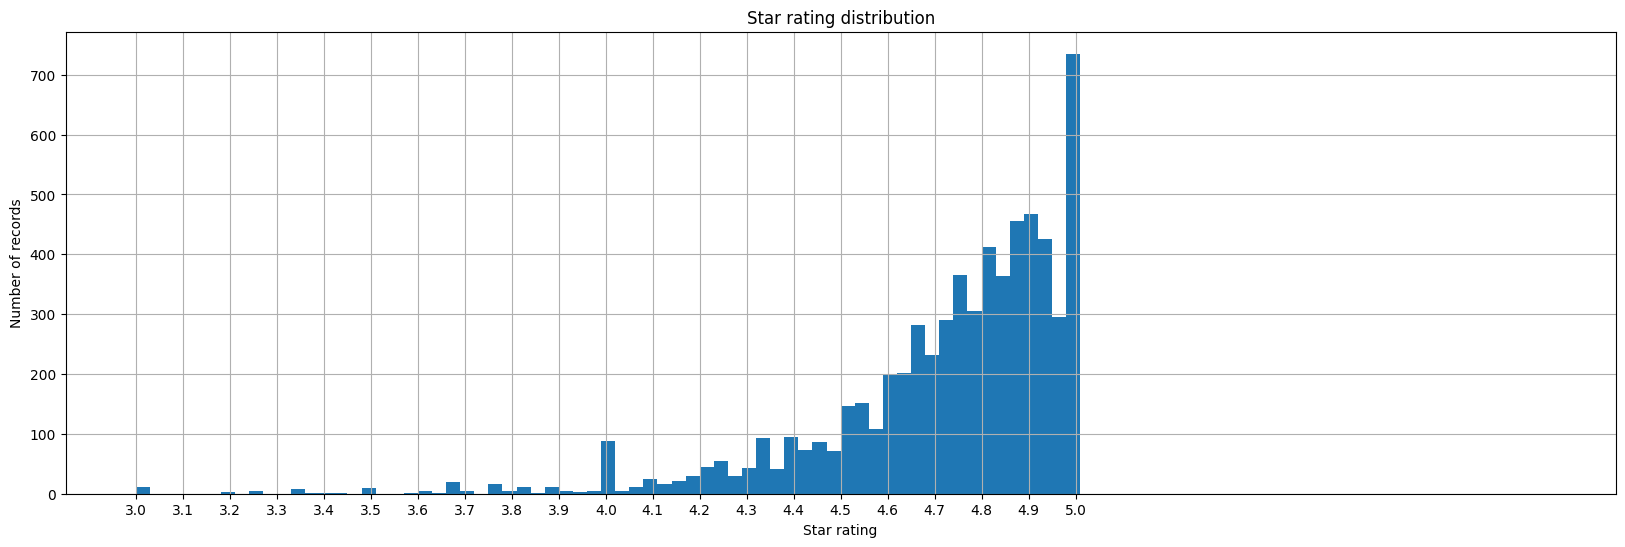

In [130]:
# Rozložení výše hodnocení
plt.figure(figsize=(20, 6))
df['star_rating'].hist(bins=100 , range=(3, 6))
plt.title('Star rating distribution')
plt.xlabel('Star rating')
plt.ylabel('Number of records')
plt.xticks(np.arange(3, 5.1, 0.1))
plt.show()

Je zřejmé, že v datech převažují záznámy s velmi kladně hodnoceným ubytováním - mezi 4 a 5 hvězdičkami. 

Shrnutí: Z průzkumové analýzy dat je zřejmé, že dataset, jenž je předmětem analýzy, je i přes sjednocení 10 pražských částí do 4 pražských celků, značně nevyvážený. Staré město (Praha 1) disponuje obroti zbylým pražským celkům výrazně mnoha záznami, a proto také výrazně více hodnotami u jednotlivých atributů, což má v konečném důsledku vliv na hodnoty některých analyzovaných charakteristik (atributů). Z výše znázorněných histogramů však pozorujeme nevyváženost i u atributů, na něž nemá počet záznamů vzhledem k celku žádný vliv. Druhým důležitým výstupem průzkumové analýzy dat je pak znalost atributů s chybějícími hodnotami. 

Vyřešení problému nevyváženosti dat i ošetření chybějících hodnot je předmět sekce Předzpracování dat.

## Předzpracování dat

Na základě průzkumové analýzy dat bylo zjištěno:
* 8023 chybějících hodnot u atributu neighbourhood_group"
* 8023 chybějících hodnot u atributu "license"
* 1619 chybějících hodnot u atributu "star_rating" 
* 877 chybějících hodnot u atributu "last_review"
* 877 chybějících hodnot u atributu "reviews_per_month".

Vzhledem k tomu, že počet chybějících hodnot u atributů "neighbourhood_group" a "license" představuje celkový počet záznamů, byly tyto dva sloupce z datového souboru odstraněny. Atribut "last_review", společně s atributy "name", "host_id", "host_name", "latitude" a "longitude" nemá v rámci definované úlohy dopad na její výsledek, proto byly odstraněny i tyto atributy.  
 
Chybějící hodnoty atributů "star_rating" a "reviews_per_month" pak byly nahrazeny pomocí K-means podbnosti, tj. podobností nejbližšího souseda. V případě, že hodnota celkového počtu hodnocení, tj. hodnota atributu "number_of_reviews" byla pro daný záznam rovna nule, pak byl počet hodnocení za jeden měsíc, tj. "reviews_per_month", speciálně nastaven také na 0.

Budeme modelovat cenu pomocí regresního modelu.

Konkrétní implementace všech výše uvedených změn je předmětem níže uvedeného kódu. 

In [131]:
# --- 0) Rozdělení dat ---
data = df[['neighbourhood','room_type','price',
           'minimum_nights','number_of_reviews','reviews_per_month',
           'calculated_host_listings_count','availability_365',
           'number_of_reviews_ltm','star_rating']]


X_train, X_test, y_train, y_test = train_test_split(
    data.drop('price',axis=1),
    data['price'],
    test_size=0.3,
    random_state=42
)

# --- 1) Preprocessing pipelines ---
# Numerické a kategoriální sloupce
numeric_feats = [
    'minimum_nights','number_of_reviews','reviews_per_month',
    'calculated_host_listings_count','availability_365',
    'number_of_reviews_ltm','star_rating'
]
categorical_feats = ['neighbourhood','room_type']

# Pro numerická data: nulové reviews_per_month → 0, imputace mediánem, škálování
numeric_transformer = Pipeline([
    ('fill_reviews',   SimpleImputer(
         strategy='constant', fill_value=0
     )),  # to pokryje NaN u reviews_per_month když reviews=0
    ('imputer',        SimpleImputer(strategy='median')),
    ('scaler',         MinMaxScaler())
])

# Pro kategorie: imputace nejčastější a one‑hot enkódování
categorical_transformer = Pipeline([
    ('imputer',        SimpleImputer(strategy='most_frequent')),
    ('onehot',         OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_feats),
    ('cat', categorical_transformer, categorical_feats),
])

#data.to_csv(path_or_buf=r'C:\Users\neumannv\Desktop\škola\DataX\Airbnb_data_analysis\data\processed\data.csv')

## Modelování

 Pro predikci ceny ubytování byly využity dva modely: náhodný les a gradientní boosting (XGBoost).
 Náhodný les je robustní k šumu a dobře zvládá jak numerické, tak kategorické proměnné bez nutnosti složitého škálování,
 zatímco XGBoost díky postupnému přidávání stromů často dosahuje vyšší predikční přesnosti, ale vyžaduje pečlivé
 ladění hyperparametrů. Vstupní data byla předzpracována přes ColumnTransformer: numerické proměnné byly
 imputovány mediánem a následně škálovány, chybějící recenze nastaveny na 0, kategorie byly imputovány
 nejčastější hodnotou a zakódovány one‑hot enkodérem. Výběr nejlepších hyperparametrů proběhl pomocí
 pětinásobné křížové validace (GridSearchCV) s metrikou RMSE. Nakonec byl nejlepší model ověřen na
 samostatné testovací sadě a vyhodnocen pomocí RMSE a MAE.


In [132]:
# --- 2) Modely a přehled hyper‑parametrů pro ladění ---
models       = {}
param_grids  = {}

# Random Forest
models['rf'] = Pipeline([
    ('preproc', preprocessor),
    ('rf', RandomForestRegressor(random_state=42))
])
param_grids['rf'] = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth':    [None, 10, 20],
    'rf__min_samples_leaf': [1, 3]
}

# XGBoost
models['xgb'] = Pipeline([
    ('preproc', preprocessor),
    ('xgb', XGBRegressor(
        objective='reg:squarederror', random_state=42, 
        verbosity=0
    ))
]
)
param_grids['xgb'] = {
    'xgb__n_estimators':     [100, 200],
    'xgb__max_depth':        [4, 6, 8],
    'xgb__learning_rate':    [0.01, 0.1],
    'xgb__subsample':        [0.7, 1.0]
}

# --- 3) GridSearchCV s 5‑fold CV (na RMSE) ---
cv_results = {}
for name, pipeline in models.items():
    print(f"\n» Optimalizování modelu: {name}")
    gs = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids[name],
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    gs.fit(X_train, y_train)
    print(f"  ✓ Best params: {gs.best_params_}")
    print(f"  ✓ CV RMSE: {-gs.best_score_:.2f}")
    cv_results[name] = gs

# --- 4) Vyhodnocení na testovací sadě ---
best_name = min(cv_results, key=lambda n: -cv_results[n].best_score_)
best_model = cv_results[best_name].best_estimator_

y_pred = best_model.predict(X_test)
print(f"\n=== Nejlepší model: {best_name} ===")
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test MAE: ", mean_absolute_error(y_test, y_pred))


» Optimalizování modelu: rf
Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('fill_reviews',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant')),
                                                                                         ('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['minimum_nights',
                                                                          'number_of_reviews',
                                                                          'reviews_per_month',
                                                                          'calculated_host_listings_count',
                                                                          'availabili...
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['neighbourhood',
                                                                          'room_type'])])),
                                       ('rf',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [None, 10, 20],
                         'rf__min_samples_leaf': [1, 3],
                         'rf__n_estimators': [100, 200]},
             scoring='neg_root_mean_squared_error', verbose=1)

  ✓ Best params: {'rf__max_depth': None, 'rf__min_samples_leaf': 3, 'rf__n_estimators': 200}
  ✓ CV RMSE: 7167.87

» Optimalizování modelu: xgb
Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('fill_reviews',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant')),
                                                                                         ('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['minimum_nights',
                                                                          'number_of_reviews',
                                                                          'reviews_per_month',
                                                                          'calculated_host_listings_count',
                                                                          'availabili...
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'xgb__learning_rate': [0.01, 0.1],
                         'xgb__max_depth': [4, 6, 8],
                         'xgb__n_estimators': [100, 200],
                         'xgb__subsample': [0.7, 1.0]},
             scoring='neg_root_mean_squared_error', verbose=1)

  ✓ Best params: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 8, 'xgb__n_estimators': 100, 'xgb__subsample': 0.7}
  ✓ CV RMSE: 6712.86

=== Nejlepší model: xgb ===
Test RMSE: 6656.943442752086
Test MAE:  1861.7191162109375


Naším cílem bylo porovnat dvě metody – náhodný les (RF) a gradientní boosting (XGBoost) při predikci ceny ubytování. Pro oba modely jsme použili pětinásobnou křížovou validaci s RMSE jako hlavní metrikou pro porovnání:
Random Forest dosáhl nejlepších hyperparametrů n_estimators=200, min_samples_leaf=3, max_depth=None, s průměrným RMSE na validačních datech 7167,87.

XGBoost dosahuje nejlepších výsledků při learning_rate=0.1, max_depth=8, n_estimators=100 a subsample=0.7, přičemž jeho CV RMSE kleslo na 6712,86.

Jako nejlepší model se ukázal XGBoost, který nejenže překonal RF o přibližně 455 (CV RMSE), ale potvrdil svou převahu i na zcela oddělené testovací sadě:

Test RMSE: 6 656,94

Test MAE: 1 861,72

To znamená, že průměrná kvadratická odchylka predikovaných cen je necelých 6 657 a průměrná absolutní odchylka přibližně 1 862. XGBoost tedy poskytuje stabilnější a přesnější odhady než náhodný les, zvláště pokud jde o celkovou rozptyl chyby (RMSE). MAE ukazuje, že typická „absolutní“ chyba je okolo 1 900, což v kontextu průměrné ceny (např. 2–3 tisíce na noc) může být stále výrazné a naznačuje prostor pro další zlepšení – třeba přidáním nových featur (sezónnost, lokalita v rámci čtvrti, interakce předchozích atributů).

# Přesnost modelu

In [133]:
# --- 1) Random Forest ---
best_rf = cv_results['rf'].best_estimator_

# R² na tréninku
r2_rf_train = best_rf.score(X_train, y_train)
print("RF R² (train):", r2_rf_train)

# R² na testu
r2_rf_test = best_rf.score(X_test, y_test)
print("RF R² (test):", r2_rf_test)

# případně explicitně přes funkci
y_rf_pred = best_rf.predict(X_test)
print("RF R² (test) [r2_score]:", r2_score(y_test, y_rf_pred))


# --- 2) XGBoost ---
best_xgb = cv_results['xgb'].best_estimator_

# R² na tréninku
r2_xgb_train = best_xgb.score(X_train, y_train)
print("XGB R² (train):", r2_xgb_train)

# R² na testu
r2_xgb_test = best_xgb.score(X_test, y_test)
print("XGB R² (test):", r2_xgb_test)

# explicitně přes funkci
y_xgb_pred = best_xgb.predict(X_test)
print("XGB R² (test) [r2_score]:", r2_score(y_test, y_xgb_pred))


RF R² (train): 0.5014655769704415
RF R² (test): 0.06469164818559026
RF R² (test) [r2_score]: 0.06469164818559026
XGB R² (train): 0.9397171139717102
XGB R² (test): -0.01761031150817871
XGB R² (test) [r2_score]: -0.01761031150817871


Výsledky ukazují, že náhodný les dosahuje na tréninkových datech středně silného vysvětlení variability (R² ≈ 0,50), ale na testovací sadě jeho schopnost generalizace prudce klesá (R² ≈ 0,06), což naznačuje mírné přeučení a slabou přesnost mimo tréninkovou množinu. XGBoost naopak „perfektně“ sedí na tréninku (R² ≈ 0,94), ale na datech, která neviděl, jeho výkon padá dokonce do záporných hodnot (R² ≈ –0,02), což ukazuje na výrazné přeučení a nevhodné nastavení modelu pro reálné predikce.

## Evaluace modelu

# Residual plot

<Figure size 1600x800 with 0 Axes>

(286.94244384765625, 17430.613515625024)

(-8861.03607421875, 17115.32702545174)

Text(0.5, 0, 'Predikovaná cena')

Text(0, 0.5, 'Reziduum (skutečná – predikovaná)')

Text(0.5, 1.0, 'Residual Plot (1.–99. percentil)')

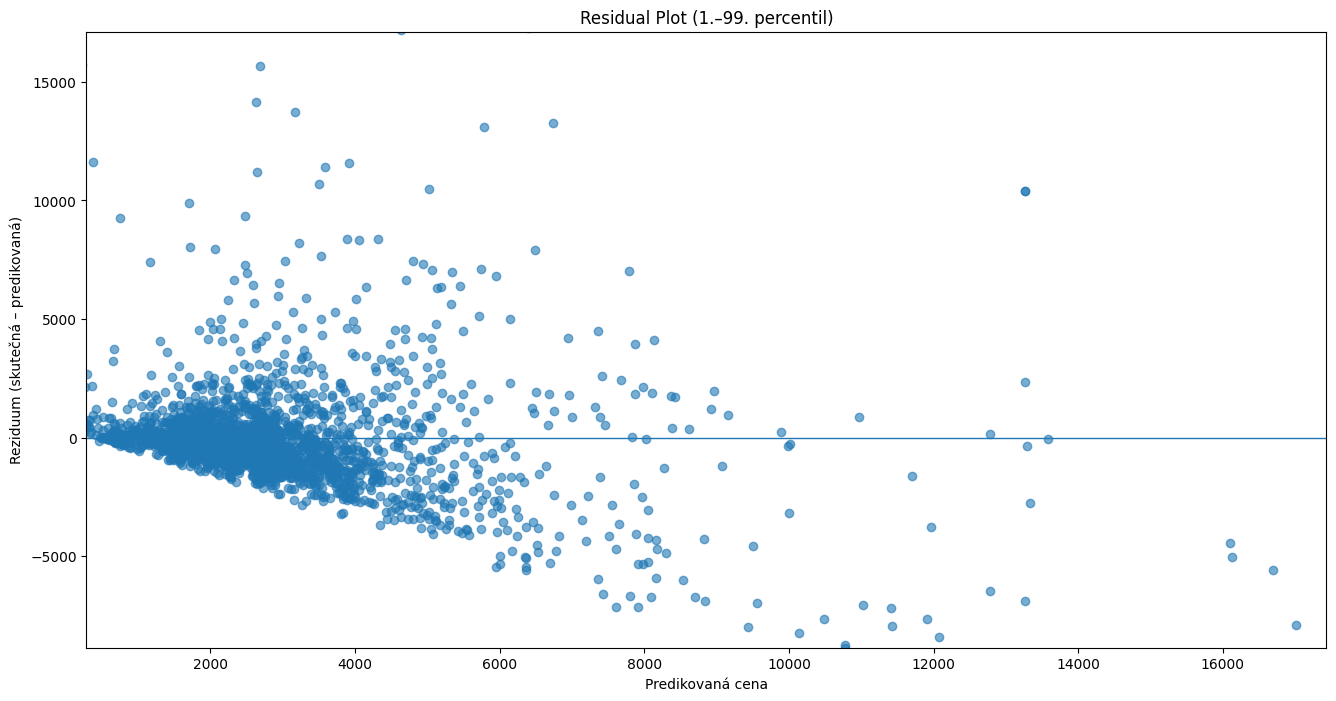

In [134]:
residuals = y_test - y_pred

# Určíme 1. a 99. percentil residuíí a predikcí (jsou tam outliery, tak to nevypada celkove dobre)
res_lower, res_upper = np.percentile(residuals, [1, 99])
pred_lower, pred_upper = np.percentile(y_pred,   [1, 99])

# --- Residual plot se zoomem na 1–99 % rozsah ---
plt.figure()
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, linewidth=1)
plt.xlim(pred_lower, pred_upper)
plt.ylim(res_lower, res_upper)
plt.xlabel('Predikovaná cena')
plt.ylabel('Reziduum (skutečná – predikovaná)')
plt.title('Residual Plot (1.–99. percentil)')
plt.show()

Trojúhelníkový rozptyl směrem doprava – jak roste predikovaná cena, tak se rozptyl reziduí zvětšuje.
Znamená to heteroskedasticitu – model dělá větší chyby u dražších ubytování a to tím, že je nadhodnocuje

# Histogram chyb

<Figure size 1600x800 with 0 Axes>

(array([  4.,   9.,   9.,   7.,  16.,  28.,  45.,  98., 314., 698., 644.,
        226., 109.,  45.,  23.,  25.,   9.,  11.,  11.,   8.,   1.,   2.,
          4.,   4.,   0.,   3.,   2.,   0.,   2.,   0.]),
 array([-8861.0361, -7995.1573, -7129.2785, -6263.3998, -5397.521 ,
        -4531.6422, -3665.7635, -2799.8847, -1934.0059, -1068.1271,
         -202.2484,   663.6304,  1529.5092,  2395.3879,  3261.2667,
         4127.1455,  4993.0242,  5858.903 ,  6724.7818,  7590.6606,
         8456.5393,  9322.4181, 10188.2969, 11054.1756, 11920.0544,
        12785.9332, 13651.8119, 14517.6907, 15383.5695, 16249.4483,
        17115.327 ]),
 <BarContainer object of 30 artists>)

Text(0.5, 0, 'Reziduum (skutečná – predikovaná)')

Text(0, 0.5, 'Počet')

Text(0.5, 1.0, 'Histogram reziduí (1.–99. percentil)')

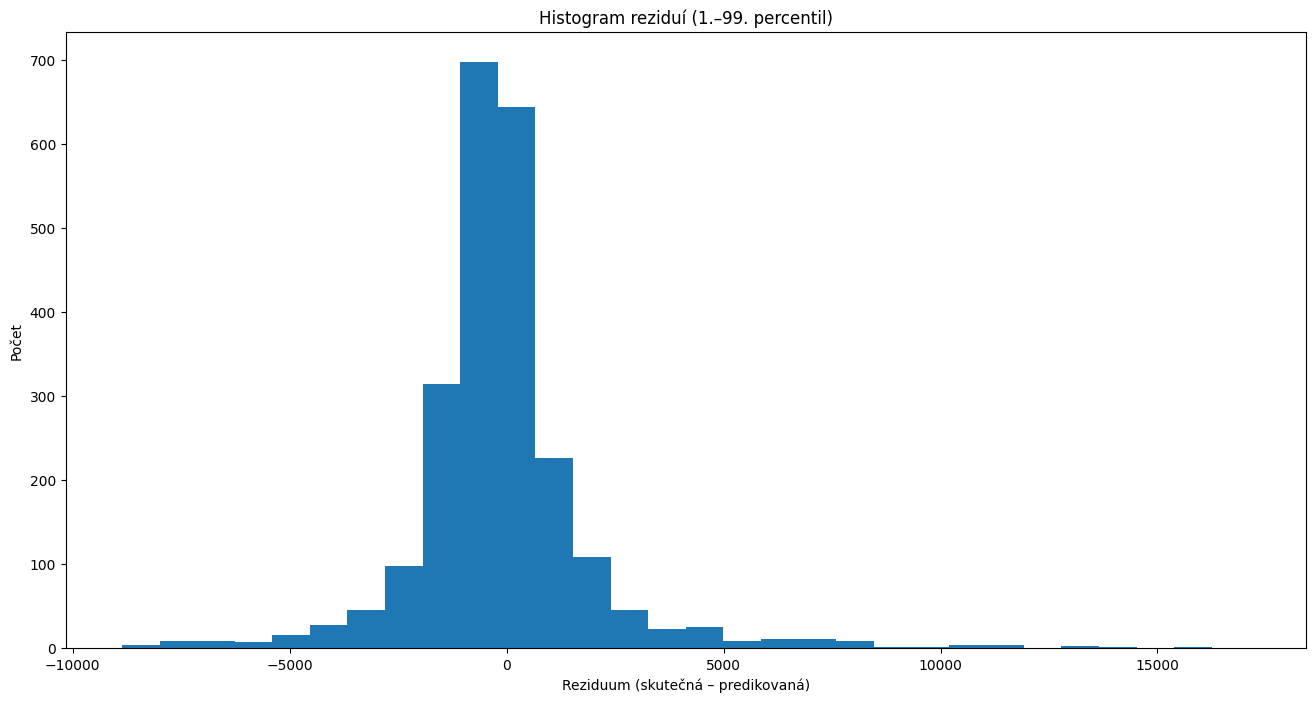

In [135]:
plt.figure()
plt.hist(residuals, bins=30, range=(res_lower, res_upper))
plt.xlabel('Reziduum (skutečná – predikovaná)')
plt.ylabel('Počet')
plt.title('Histogram reziduí (1.–99. percentil)')
plt.show()

## Evaluace modelu

Zjištění nejzádasnějších featur

 98%|===================| 2369/2407 [00:21<00:00]        C:\Users\neumannv\AppData\Local\Temp\ipykernel_22764\3090860210.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, features=X_test_trans, feature_names=feature_names)


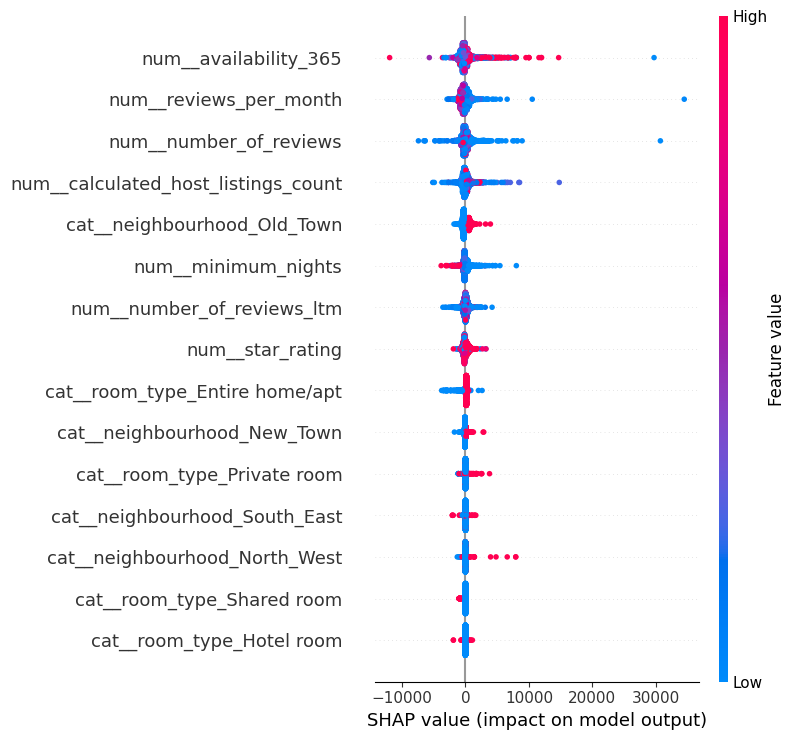

In [143]:
xgb_model = best_model.named_steps['xgb']
preprocessor = best_model.named_steps['preproc']

# Převeď testovací data pomocí preprocesoru
X_test_trans = preprocessor.transform(X_test)

# Získej názvy všech feature po transformaci (včetně one-hot encoded)
feature_names = preprocessor.get_feature_names_out()

# Vytvoř SHAP explainer 
explainer = shap.Explainer(xgb_model, X_test_trans, feature_names=feature_names)
shap_values = explainer(X_test_trans)

shap.summary_plot(shap_values, features=X_test_trans, feature_names=feature_names)



In [144]:
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'mean_abs_shap': mean_abs_shap
}).sort_values(by='mean_abs_shap', ascending=False)

feature_importance.head(10)  # Top 10 nejvlivnějších atributů


,feature,mean_abs_shap
4,num__availability_365,758.439824
2,num__reviews_per_month,501.913701
1,num__number_of_reviews,497.604503
3,num__calculated_host_listings_count,461.444199
9,cat__neighbourhood_Old_Town,434.407328
0,num__minimum_nights,367.798726
5,num__number_of_reviews_ltm,319.753923
6,num__star_rating,287.828006
11,cat__room_type_Entire home/apt,257.911973
7,cat__neighbourhood_New_Town,112.044970


### Klasifikační reporty

## Závěr